In [1]:
# imports
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline

[ 36.30676937  32.14521404  52.4231226  ...,  12.97544551  11.35612219
   4.72694817] [ 5.84385112  5.61145367  6.6050722  ...,  4.14709547  3.96685774
  1.52514105] earthRad [  4.02518461e+06   5.59104958e+06   2.09901715e+06 ...,   8.49897569e+06
   5.19262572e+06   6.25736107e+01] [ 0.60628778  0.27043395  0.40948129 ...,  0.35251296  0.53111786
  0.18275781] (25000,) (25000,) (25000,) (25000,)


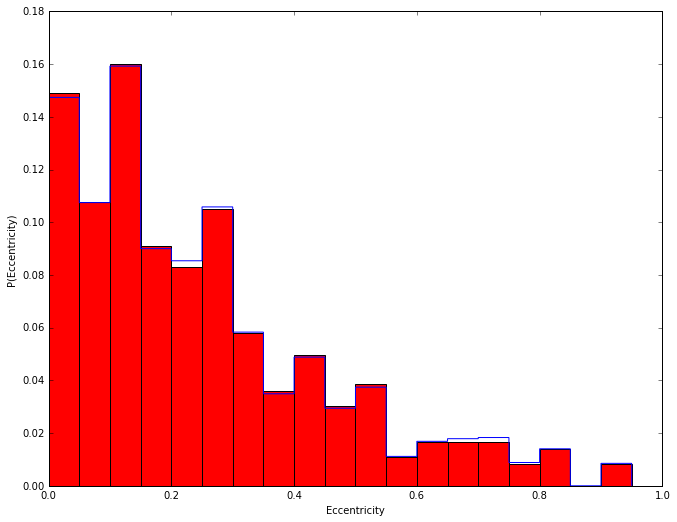

In [63]:
# now able to run entire notebook and produce the relevant parameters and figures.  

data = QTable.read('probecc_comma.dat',format='ascii.no_header')


data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

t = 25000 # number of sims to run


n = 0
ecc_list = np.array([])
while n <= t-1:
    r = (np.random.sample(1)) #some y value (percentage)
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list=np.append(ecc_list,ecc)
    n += 1
    continue
ecc_hist = ax.hist(ecc_list,bins=x,weights=np.zeros_like(ecc_list)+1./ecc_list.size,histtype='step',color='blue')

# now to generate ICs and their files. 
# clears vars and generates new randoms
mass_list = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
ecc = ecc_list
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = np.random.uniform(0.7,1.4,25000) #[0.7,1.4] R_sun
rad_list = np.random.uniform(0.5,10,25000) * u.earthRad # [0.5,10] R_earth;  
Qp = np.array([]) # [30,300] # [10**6,10**7]
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]
Period = np.array([])
semi = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU
Ages = np.random.uniform(2*10**9,8*10**9,25000) # [2,8] Gyrs
R_crit = 2 * u.earthRad


# mass calculations
def calc_mass_l2(radius):
    r = radius
    mass = ((r/const.R_earth)**(3.68))*const.M_earth
    return mass

def calc_mass_g2(radius):
    r = radius
    r = r.to(u.cm)
    volume = (4*np.pi*r**3)/3
    density = (1*u.g)/(1*u.cm)**3
    mass = volume * density
    return mass

# determining mass and Qp based on radius
for r in rad_list:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(30,301)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
        Qplanet = np.random.uniform(10**6,(10**7)+1)
    mass_list = np.append(mass_list,mass.value)
    Qp = np.append(Qp,Qplanet)

        


print (mass_list,rad_list,Qp,ecc_list,mass_list.shape,rad_list.shape,Qp.shape,ecc_list.shape)
rad_list = rad_list.value

3938 21062 25000


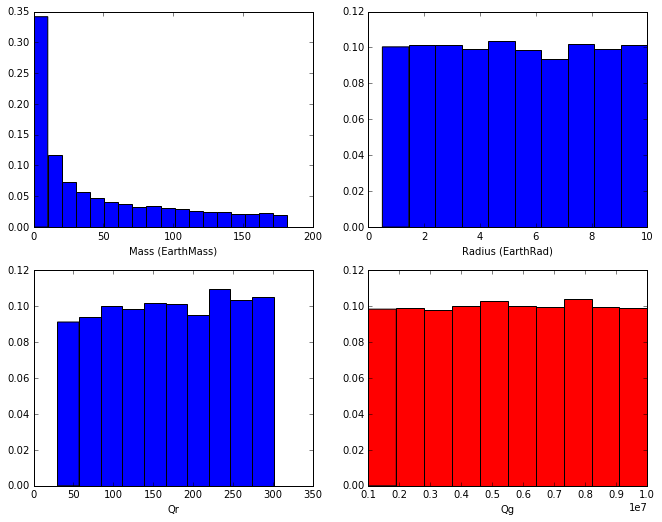

In [64]:
# now to graph above params in histograms
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list)-min(mass_list)
ax[0,0].hist(mass_list,bins=18,weights=np.zeros_like(mass_list)+1./mass_list.size) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(rad_list,weights=np.zeros_like(rad_list)+1./rad_list.size) # Uniform
q_lower = np.where(Qp<=301)
q_upper = np.where(Qp>301) 
ax[1,0].hist(Qp[q_lower],weights=np.zeros_like(Qp[q_lower])+1./Qp[q_lower].size) 
ax[1,1].hist(Qp[q_upper],weights=np.zeros_like(Qp[q_upper])+1./Qp[q_upper].size,color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

print(Qp[q_lower].size,Qp[q_upper].size,Qp[q_lower].size + Qp[q_upper].size)

In [67]:
# Parameters still need to do, by file
# b.in
name_b = 'b'
modules_b = 'eqtide'
sTideModel = 'p2'
dMass = (mass_list)*(-1) # sets to earth masses; this isnt working!!
dRadius = (rad_list)*(-1) # sets to earth radii
bForceEqSpin = 1
#dRotPeriod = -1 
dObliquity = 0 
dRadGyra = 0.5
dTidalQ = Qp 
dK2 = 0.3
#dMaxLockDiff = 0.1 
saTidePerts = 'star'
saOutputOrder_b = 'Time Semim Ecce'

#star.in
name_star = 'star'
modules_star = 'eqtide'
dMass_star = np.random.uniform(0.7,1.4,25000) #solar masses; convert to earth masses:
dRadius_star = dMass_star * 0.0048 # * ratio of solar radii to au
dObliquity_star = 0  
bForceEqSpin_star = 1
#dRotPeriod_star = -83 
dRadGyra_star = 0.5 
dTidalQ_star = 10**6
dK2_star = 0.3 
saTidePerts_star = 'b'
saOutputOrder_s = 'Time'

#vpl.in
Sys_name = 'system'
iVerbose = 5
bOverwrite = 1
saBodyFiles = 'star.in b.in'  
UnitMass = 'solar' 
UnitLength = 'aU'  
UnitTime = 'YEARS'
UnitAngle = 'd'
UnitTemp = 'K'
bDoLog = 1
iDigits = 6
dMinValue = 10**(-10)
bDoForward = 1
bVarDt = 1
dEta = 0.01
dStopTime = Ages
dOutputTime = 10**9

#any extra conversions for units defined in vpl.in; therefore everything needs to be in M_earth or R_earth.
print ('ICs set.')



ICs set.


In [69]:
# need to make 25000 folders, 1 to 25000; DONT RUN THIS CELL UNLESS YOU WANNA LOSE ALL YOUR RUNS
import os
import shutil
from IPython.core.debugger import Tracer
import subprocess
shutil.rmtree('./runs/') # removes current runs; 

t = t # number of runs


n = 0
while n <= t-1: # will make n <= x amount of folders; (25000);
    # make strings of values; b.in
    name_idx = '%05i'%n
    mass_str = str(dMass[n]) 
    radius_str = str(dRadius[n])
    eqspin_str = str(bForceEqSpin)
    obl_str = str(dObliquity)
    radgy_str = str(dRadGyra)
    ecc_str = str(ecc[n])
    semi_str = str(semi[n])
    q_str = str(dTidalQ[n])
    dK2_str = str(dK2)
    perts_str = str(saTidePerts)
    outorder_str = str(saOutputOrder_b)
    #star.in
    name_star = name_star
    modules_star = modules_star
    strMass_str = str(dMass_star[n])
    strRad_str = str(dRadius_star[n])
    strObl_str = str(dObliquity_star)
    strEqSpin_str = str(bForceEqSpin_star)
    strRadGyr_str = str(dRadGyra_star)
    strTidalQ_str = str(dTidalQ_star)
    strdK2_str = str(dK2_star)
    saTidePerts_star = saTidePerts_star
    strsaOutputOrder = saOutputOrder_s
    #vpl.in
    sys_name = Sys_name
    iVerbose_str = str(iVerbose)
    bOverwrite_str = str(bOverwrite)
    saBodyFiles = saBodyFiles
    UnitMass = UnitMass
    UnitLength = UnitLength
    UnitTime = UnitTime
    UnitAngle = UnitAngle
    UnitTemp = UnitTemp
    bDoLog_str = str(bDoLog)
    iDigits_str = str(iDigits)
    dMinValue_str = str(dMinValue)
    bDoForward_str = str(bDoForward)
    bVarDt_str = str(bVarDt)
    dEta_str = str(dEta)
    dStopTime_str = str(int(dStopTime[n]))
    dOutputTime_str = str(dOutputTime)
    
    os.makedirs('./runs/'+name_idx)
    b = open('./runs/'+name_idx+'/b.in','w')
    b_content = 'sName\t'+ name_b + '\nsaModules\t'+modules_b+'\nsTideModel\t'+sTideModel+'\n\ndMass\t'+mass_str+'\ndRadius\t'+radius_str+'\ndObliquity\t'+obl_str+'\ndRadGyra\t'+radgy_str+'\n\ndEcc\t'+ecc_str+'\ndSemi\t'+semi_str+'\n\nbForceEqSpin\t'+eqspin_str+'\ndTidalQ\t'+q_str+'\ndK2\t'+dK2_str+'\nsaTidePerts\t'+perts_str+'\n\nsaOutputOrder\t'+outorder_str+'\n'
    b.write(b_content)
    b.close()
    
    star = open('./runs/'+name_idx+'/star.in','w')
    star_content = 'sName\t'+name_star+'\nsaModules\t'+modules_star+'\n\ndMass\t'+strMass_str+'\ndRadius\t'+strRad_str+'\ndObliquity\t'+strObl_str+'\nbForceEqSpin\t'+strEqSpin_str+'\ndRadGyra\t'+strRadGyr_str+'\n\ndTidalQ\t'+strTidalQ_str+'\ndK2\t'+strdK2_str+'\n\nsaTidePerts\t'+saTidePerts_star+'\n\nsaOutputOrder\t'+strsaOutputOrder+'\n'
    star.write(star_content)
    star.close()
    
    vpl = open('./runs/'+name_idx+'/vpl.in','w')
    vpl_content = 'sSystemName\t'+sys_name+'\niVerbose\t'+iVerbose_str+'\nbOverwrite\t'+bOverwrite_str+'\n\nsaBodyFiles\t'+saBodyFiles+'\n\nsUnitMass\t'+UnitMass+'\nsUnitLength\t'+UnitLength+'\nsUnitTime\t'+UnitTime+'\nsUnitAngle\t'+UnitAngle+'\nsUnitTemp\t'+UnitTemp+'\n\nbDoLog\t'+bDoLog_str+'\niDigits\t'+iDigits_str+'\ndMinValue\t'+dMinValue_str+'\n\nbDoForward\t'+bDoForward_str+'\nbVarDt\t'+bVarDt_str+'\ndEta\t'+dEta_str+'\ndStopTime\t'+dStopTime_str+'\ndOutputTime\t'+ dOutputTime_str+'\n'
    vpl.write(vpl_content)
    vpl.close()
 
    n += 1
    

s = 0      #runs each simulation
while s <= t-1:
    name_idx = '%05i'%s
    folder_name = name_idx
    working_directory = './runs/'+folder_name
    p = subprocess.call(['vplanet vpl.in'], shell=True, cwd = working_directory)
    s += 1
    continue



print('Runs Completed')


In [70]:
# extracts output from system.log for each run

import re
from IPython.core.debugger import Tracer
t = 25000
x = np.arange(0,15.5,0.5) # Period
y = np.arange(0,10.5,0.5) # Radius
z = np.array([]) # Avg. Final Ecc.
ymax = 10
xmax = 15

final_rad = np.array([]) # line 241 in system.log
final_per = np.array([]) # line 255 in system.log
final_ecc = np.array([]) # line 252 in system.log
folders = np.array([]) # corresponding folders
# need to read in the data to calc ecc; need final rad, orbperiod, ecc:
# define respective regex
rad_regex = re.compile(r':.*')
per_regex = re.compile(r':.*')
ecc_regex = re.compile(r':.*')

n = 0
while n <= t-1:                                      # builds the final vars from output files
    name_idx = '%05i'%n
    folder_name = name_idx
    wd = './runs/'+folder_name
    log = open(wd+'/system.log','r')
    foldercount = open('./runs/foldercount.txt','w') #count to know which run it stops pulling data from
    foldcount_content = folder_name+' DONE'
    foldercount.write(foldcount_content)
    foldercount.close()
    for i, line in enumerate(log):
        if i == 240: #radius
            radius = line
            rad = rad_regex.search(radius)
            rad = rad.group()
            rad = rad[2:]
            rad = float(rad)
            final_rad = np.append(final_rad,rad)
        elif i == 254: #period
            period = line
            per = per_regex.search(period)
            per = per.group()
            per = per[2:]
            per = float(per)
            final_per = np.append(final_per,per)
        elif i == 251: #ecc
            ecc = line
            e = ecc_regex.search(ecc)
            e = e.group()
            e = e[2:]
            e = float(e)
            final_ecc = np.append(final_ecc,e)
    n += 1

# now to calc z (avg final ecc) for each bin. 
# convert to units:
final_rad = final_rad * u.m
final_rad = final_rad.to(u.earthRad)
final_rad = final_rad.value
final_per = final_per * u.s
final_per = final_per.to(u.day)
final_per = final_per.value

final = np.array([final_rad,final_per,final_ecc])
final = final.transpose() # each row is entry, 1st column is rad, 2nd column is per, 3rd col is ecc. 

# final[0:1]= final_rad
# final[1:2] = final_per
# final[2:3] = final_ecc

final, final.shape

(array([[  5.84381863,   7.04579051,   0.605105  ],
        [  5.61142158,   1.59211921,   0.068856  ],
        [  6.60503476,   8.19648958,   0.408537  ],
        ..., 
        [  4.14707212,  15.92444444,   0.352511  ],
        [  3.96683608,  10.89565972,   0.53106   ],
        [  1.52513242,  13.5324537 ,   0.165384  ]]), (25000, 3))

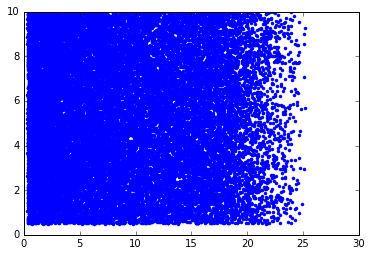

In [71]:
fix,ax = plt.subplots(1,1)
ax.plot(final_per,final_rad,'.')
#final
#semi.shape
# check units


In [72]:
#calculates the avg final eccentricity for each bin

import os
import math
binwidth = 0.5
avgfin_ecc = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
bin_vals = np.array([0,0,0,0,0])

for r in y:
    rbin_l = r
    rbin_u = rbin_l + binwidth
    x_avgfin_ecc = np.array([]) #list of avg ecc for a y bin along entire x axis
    for p in x:
        pbin_l = p
        pbin_u = pbin_l + binwidth
        ecclist_bin = np.array([]) #list of ecc per bin, changes with each bin; 2D Histogram
        for ent in final:
            rad = ent[0:1]
            per = ent[1:2]
            ecc = ent[2:3]
            #Tracer()()
            if rad>=rbin_l and rad<=rbin_u and per>=pbin_l and per<=pbin_u:
                ecclist_bin = np.append(ecclist_bin,ecc) 
        avgecc_bin = ecclist_bin.mean()
        x_avgfin_ecc = np.append(x_avgfin_ecc,avgecc_bin)
    #Tracer()()
    avgfin_ecc = np.vstack((avgfin_ecc,x_avgfin_ecc))
        
avgfin_ecc = avgfin_ecc[1:] # removes first line of 0's
avgfin_ecc.shape #rows,cols

/home/dm1681/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/dm1681/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(21, 31)

<a list of 9 text.Text objects>

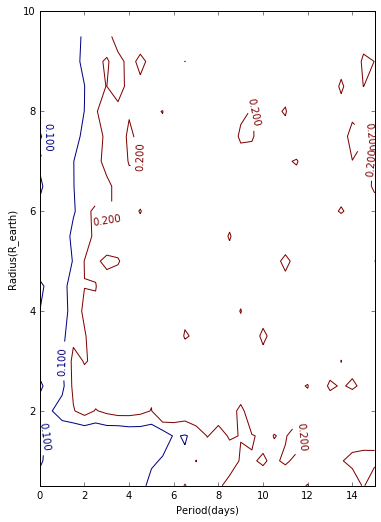

In [82]:
# makes the contour plot

fig,ax = plt.subplots(1,1)
fig.set_size_inches(6,8.5)
z = avgfin_ecc
#z = np.flipud(z)
#X,Y = np.meshgrid(x,y)
levels = [0.10,0.20]
ct = ax.contour(x,y,z,levels)
ax.set_ylabel('Radius(R_earth)')
ax.set_xlabel('Period(days)')
ax.set_ylim(0.5,10)
ax.clabel(ct,inline=True,fontsize=10)

In [83]:
fig.savefig('avg_fin_ecc.png', bbox_inches='tight')

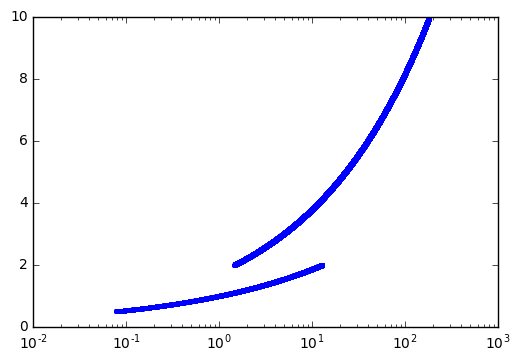

In [7]:
#Q for radius
fix,ax = plt.subplots(1,1)
ax.plot(mass_list,dRadius,'.')
ax.set_xscale('log')
#2D histogram of ecc; planets in bin vs rad,per; plt.imshow() #of sims in that cell. 
# seed for np.random
# merging? look at stop time and end of run time
# semi < 0.005
# double check fig 2
# 